In [2]:
import configparser
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
import gzip
import json
import os
import subprocess
import time
from multiprocessing import Pool
import shutil

import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import pickle
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

from data.equifold_process_input import data_process
from models import NN
from model_badge import NN as NN_grad
from openfold_light.residue_constants import restype_3to1, resname_to_idx
from refine import refine
from sequence_checks import number_sequences
from utils import compute_prediction_error, to_atom37
from utils_data import collate_fn, x_to_pdb
from align import align_ensemble

from alien.selection import EntropySelector, RandomSelector # input joint_entropy manually into _select
from alien.data import ObjectDataset # store the unlabeled dataset
from alien.stats import (joint_entropy_from_ensemble, 
                         joint_entropy_from_covariance, 
                         covariance_from_ensemble,  # use this to calculate joint entropy 
                         apply_pca) 
from alien.models import PytorchRegressor # predict ensemble 

import matplotlib.pyplot as plt 
# Font settings
plt.rcParams['font.size'] = 12                # Default font size for text
plt.rcParams['font.family'] = 'serif'         # Font family for text

# Figure settings
plt.rcParams['figure.figsize'] = (8, 6)       # Default figure size (width, height in inches)
plt.rcParams['figure.dpi'] = 100              # Resolution of the figure in dots per inch

# Axes settings
plt.rcParams['axes.grid'] = True              # Turn on/off gridlines by default
plt.rcParams['axes.titlesize'] = 20           # Font size of the plot titles
plt.rcParams['axes.labelsize'] = 16           # Font size of the x and y labels
plt.rcParams['axes.linewidth'] = 1.5          # Line width of the axes

# Tick settings
plt.rcParams['xtick.labelsize'] = 12          # Font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 12          # Font size for y-axis tick labels
plt.rcParams['xtick.major.size'] = 6          # Size of major ticks on x-axis
plt.rcParams['ytick.major.size'] = 6          # Size of major ticks on y-axis

# Line settings
plt.rcParams['lines.linewidth'] = 2.0         # Line width for plot lines
plt.rcParams['lines.markersize'] = 6          # Marker size for plot markers

# Legend settings
plt.rcParams['legend.fontsize'] = 12          # Font size for legend text
plt.rcParams['legend.loc'] = 'best'           # Default location for legends

# Save settings
plt.rcParams['savefig.dpi'] = 300             # DPI for saved figures
plt.rcParams['savefig.bbox'] = 'tight'        # Adjust layout when saving figures

# Grid settings
plt.rcParams['grid.color'] = 'gray'           # Color of gridlines
plt.rcParams['grid.linestyle'] = '--'         # Line style for gridlines
plt.rcParams['grid.linewidth'] = 0.5          # Line width for gridlines



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load model
CONFIG = configparser.ConfigParser(interpolation=configparser.ExtendedInterpolation())
CONFIG.read("configs/config_recycle.ini")

model_path = CONFIG["inference"]["model_ckpt"]
config_path = CONFIG["inference"]["config_path"]
with open(config_path, "r") as f:
    config = json.load(f)

model = NN(**config)
model_grad = NN_grad(**config)

checkpoint = torch.load(model_path, map_location="cpu")
try:
    model.load_state_dict(checkpoint["state_dict"])
    model_grad.load_state_dict(checkpoint["state_dict"])
except:
    model.load_state_dict(checkpoint)
    model_grad.load_state_dict(checkpoint["state_dict"])
model = model.to(device)
model_grad = model_grad.to(device)
model.eval()
model_grad.eval()

# load data
datafp_pickle = "/mount/UDS-ActiveLearning-Equifold/data/nanofold_input_ext_sabdab_curated_1700.pickle"
with open(datafp_pickle, 'rb') as f: 
    dataset = pickle.load(f)

/tmp/ipykernel_24061/3786813891.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location="cpu")
/mount/NanoFold/lib/python3.10/s

In [3]:
# shared selection parameter 
selection_bs = 100
dataset_index = list(range(len(dataset))) # index sequences for data object retrieval 
restype_to_idx = {(restype_3to1[resname] if resname != 'UNK' else "U"): resname_to_idx[resname] for resname in resname_to_idx}
idx_to_restype = {v:k for k, v in restype_to_idx.items()}

"""Utility functions"""
# map residue types to onehot vectors
def seq2onehot(sequences):
    """Return: 3D np.array"""
    index = np.array([[restype_to_idx[restype] if restype != '-' else restype_to_idx['U'] for restype in seq] for seq in sequences], dtype=np.int8) 
    identity_matrix = np.eye(len(restype_to_idx))
    return np.stack([identity_matrix[idx] for idx in index])

def onehot2seq(onehot): 
    reduced = np.argmax(onehot, axis=-1)
    return np.array([[idx_to_restype[idx] for idx in seq] for seq in sequences])

def extract_embedding(dataset, indices, model): 
    """
    Pass data through the model and generate a embedding with constant size to be clustered.
    """
    embedding_ensemble = []
    dataloader = DataLoader(
        dataset, 
        batch_size=1, 
        drop_last=False, 
        shuffle=False,
        num_workers=0, 
        collate_fn=collate_fn, 
        pin_memory=True, 
    )
    model.eval() 
    for data in tqdm(dataloader, desc="Generate gradient ensembles"): 
        data = data.to(device)
        model.zero_grad()
        return_dict = model(data)
        s = return_dict['final_block_emb']
        s = s.to('cpu')
        embedding_ensemble.append(s.view(-1))
    return embedding_ensemble

def joint_entropy_from_ensemble_without_pca(
    preds,
    epsilon=None,
    rel_epsilon=1e-4,
    generate=True,
    ddof=1,
    block_size=None,
    pbar=False,
):
    return joint_entropy_from_covariance(
        covariance_from_ensemble(preds, generate=generate, ddof=ddof, block_size=block_size),
        epsilon=epsilon,
        rel_epsilon=rel_epsilon,
        generate=True,
        pbar=pbar,
    )

def extract_gradient_ensemble(indices, model, full_dataset, device=device):
    """
    Return the gradient ensemble with the given dataset
    """
    gradient_ensemble = []
    dataset = Subset(full_dataset.dataset, indices)
    dataloader = DataLoader(dataset, collate_fn=collate_fn,)
    model.eval()
    num_blocks = model.num_blocks 
    for data in tqdm.tqdm(dataloader, desc="Generate gradient ensembles"): 
        data = data.to(device)
        model.zero_grad()
        return_dict = model(data, compute_loss=True, return_struct=False, is_train=False, save_grad=True)
        gradient_ensemble.append(return_dict['final_block_grad']) 
    return torch.stack(gradient_ensemble).cpu().numpy()


def kmeans_sample_batch(gradient_ensemble, indices, K, random_state=10): 
    """
    Return a selected batch with size K given the gradient ensemble and the dataset.
    """
    assert len(gradient_ensemble) == len(indices), "gradient ensemble size doesn't match the input dataset size."
    print("Clustering the ensembles...")
    kmeans = KMeans(n_clusters=K, random_state=10, init='k-means++', n_init="auto").fit(gradient_ensemble)
    centroids = kmeans.cluster_centers_
    closest, _ = pairwise_distances_argmin_min(centroids, gradient_ensemble)
    selected_data_instances = [indices[i] for i in closest]
    print("Finished clustering!")
    assert len(selected_data_instances) == K, "output batch doesn't have size equal to K."
    return np.stack(selected_data_instances), closest

class Coreset_Greedy:
    """
    Given the complete ensemble pool, sample new batch iteratively in a greedy manner. 
    """
    def __init__(self, all_ensembles):
        self.all_ensembles = np.array(all_ensembles)
        self.dset_size = len(all_ensembles)
        self.min_distances = None
        self.already_selected = []

        # reshape
        # feature_len = self.all_ensembles[0].shape[1]
        # self.all_ensembles = self.all_ensembles.reshape(-1, feature_len)


    def update_dist(self, centers, only_new=True, reset_dist=False):
        if reset_dist:
            self.min_distances = None
        if only_new:
            centers = [p for p in centers if p not in self.already_selected]
        
        if centers is not None:
            x = self.all_ensembles[centers] # pick only centers
            # print(x.shape)
            # print(self.all_ensembles.shape)
            dist = pairwise_distances(self.all_ensembles, x, metric='euclidean')

            if self.min_distances is None:
                self.min_distances = np.min(dist, axis=1).reshape(-1,1)
            else:
                self.min_distances = np.minimum(self.min_distances, dist)
    
    def sample(self, already_selected, sample_size):

        # initially updating the distances
        self.update_dist(already_selected, only_new=False, reset_dist=True)
        self.already_selected = already_selected

        new_batch = []
        for _ in range(sample_size):
            if self.already_selected == []:
                ind = np.random.choice(np.arange(self.dset_size))
            else:
                ind = np.argmax(self.min_distances)
            
            # assert ind not in already_selected
            self.update_dist([ind],only_new=True, reset_dist=False)
            new_batch.append(ind)
        
        max_distance = max(self.min_distances)
        print("Max distance from cluster : %0.2f" % max_distance.item())

        return new_batch, max_distance



100%|██████████| 630/630 [00:06<00:00, 94.55it/s] 


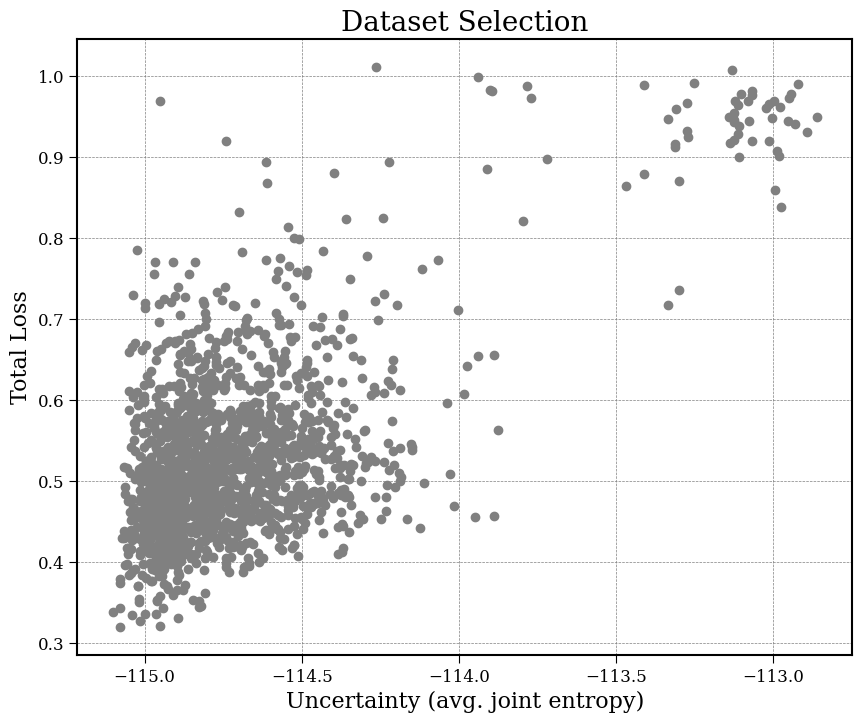

In [4]:
# dataset loss vs uncertainty
# dataset_losses = []
# dataset_loader = DataLoader(
#     dataset, 
#     batch_size=1, 
#     drop_last=False, 
#     shuffle=False,
#     num_workers=0, 
#     collate_fn=collate_fn, 
#     pin_memory=True, 
# )
# model.eval() 
# for data in tqdm(dataset_loader, desc="Calculating loss"): 
#     data = data.to(device)
#     model.zero_grad()
#     return_dict = model(data, compute_loss=True)
#     loss = return_dict['loss_total'].cpu().detach().item()
#     dataset_losses.append(loss)

# with open('ensemble_cache/dataset_losses.pickle', 'wb') as handle:
#     pickle.dump(dataset_losses, handle)

with open('ensemble_cache/dataset_losses.pickle', 'rb') as handle:
    dataset_losses = pickle.load(handle)

with open("ensemble_cache/dewdrop_ensemble.pickle", "rb") as f:
    dewdrop_ensemble = pickle.load(f)

# Calculate Joint Entropy on ensemble 
jen = joint_entropy_from_ensemble_without_pca(
    preds=dewdrop_ensemble,
    epsilon=6e-3,
    block_size=50,
    pbar=True
)

dataset_uncertainty = jen.mean(axis=-1)


plt.figure(figsize=(10, 8))
plt.title("Dataset Selection")
plt.xlabel("Uncertainty (avg. joint entropy)")
plt.ylabel("Total Loss")
plt.scatter((dataset_uncertainty.cpu().detach().numpy()), dataset_losses, color='grey', label='DATASET')

## Coreset

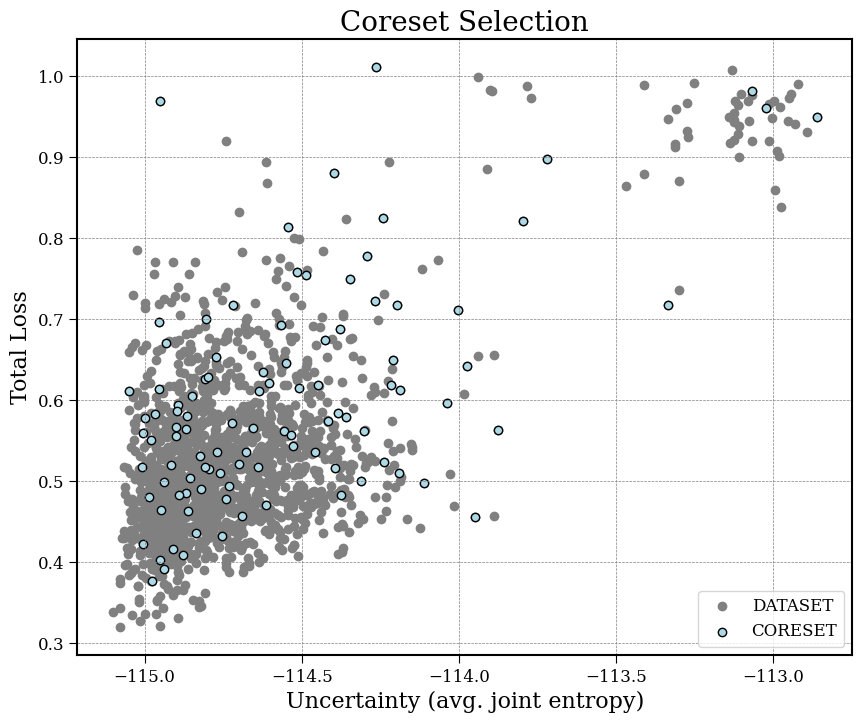

In [5]:
# coreset selection 
# torch.cuda.empty_cache()
# # extract the sequences' embeddings 
# sequences_embedding = extract_embedding(dataset, dataset_index, model)


# # pad the embeddings to fix length
# maxlen = max(len(s) for s in sequences_embedding)
# for si in range(len(sequences_embedding)): 
#     p1d = (0, maxlen-len(sequences_embedding[si]))
#     if p1d[1] != 0: 
#         sequences_embedding[si] = torch.nn.functional.pad(sequences_embedding[si], p1d, 'constant', 0.0)
# sequences_embedding = torch.stack(sequences_embedding).cpu().detach().numpy()

# coreset_obj = Coreset_Greedy(all_ensembles=sequences_embedding)
# coreset_pool = []
# coreset_pool.append(np.random.randint(0, len(sequences_embedding)))
# new_indices, max_distance = coreset_obj.sample(already_selected=coreset_pool, sample_size=selection_bs-1)
# coreset_pool.extend(new_indices)

# np.save("ensemble_cache/coreset_selection_indices.npy", coreset_pool)


# calculate prediction error for the selected batch
coreset_pool = np.load("ensemble_cache/coreset_selection_indices.npy")

plt.figure(figsize=(10, 8))
plt.title("Coreset Selection")
plt.xlabel("Uncertainty (avg. joint entropy)")
plt.ylabel("Total Loss")
plt.scatter((dataset_uncertainty.cpu().detach().numpy()), dataset_losses, color='grey', label='DATASET')
plt.scatter((dataset_uncertainty.cpu().detach().numpy()[coreset_pool]), np.array(dataset_losses)[coreset_pool], label="CORESET", color='lightblue', edgecolors='black', linewidths=1)
plt.legend()
plt.savefig("graphs/coreset_loss_v_uncertainty.png")

## Kmeans

In [6]:
# # diversity selection 
# torch.cuda.empty_cache()
# # extract the sequences' embeddings 
# sequences_embedding = extract_embedding(dataset, dataset_index, model)

# # pad the embeddings to fix length
# maxlen = max(len(s) for s in sequences_embedding)
# for si in range(len(sequences_embedding)): 
#     p1d = (0, maxlen-len(sequences_embedding[si]))
#     if p1d[1] != 0: 
#         sequences_embedding[si] = torch.nn.functional.pad(sequences_embedding[si], p1d, 'constant', 0.0)
# sequences_embedding = torch.stack(sequences_embedding).cpu().detach().numpy()

# from sklearn.cluster import KMeans
# from sklearn.metrics import pairwise_distances_argmin_min
# kmeans = KMeans(n_clusters=selection_bs, random_state=42)
# kmeans.fit(sequences_embedding)
# centroids = kmeans.cluster_centers_
# diversity_indices = pairwise_distances_argmin_min(centroids, sequences_embedding)[0]

# # save the indices
# np.save("ensemble_cache/diversity_selection_indices.npy", diversity_indices)

# # save diversity selection 
# diversity_selection = [dataset[idx] for idx in diversity_indices]
# with open("ensemble_cache/diversity_selection.pickle", "ab") as f:
#     pickle.dump(diversity_selection, f)


# diversity_indices = np.load("ensemble_cache/diversity_selection_indices.npy")

# # read diversity selection 
# with open("ensemble_cache/diversity_selection.pickle", "rb") as f:
#     diversity_selection = pickle.load(f)

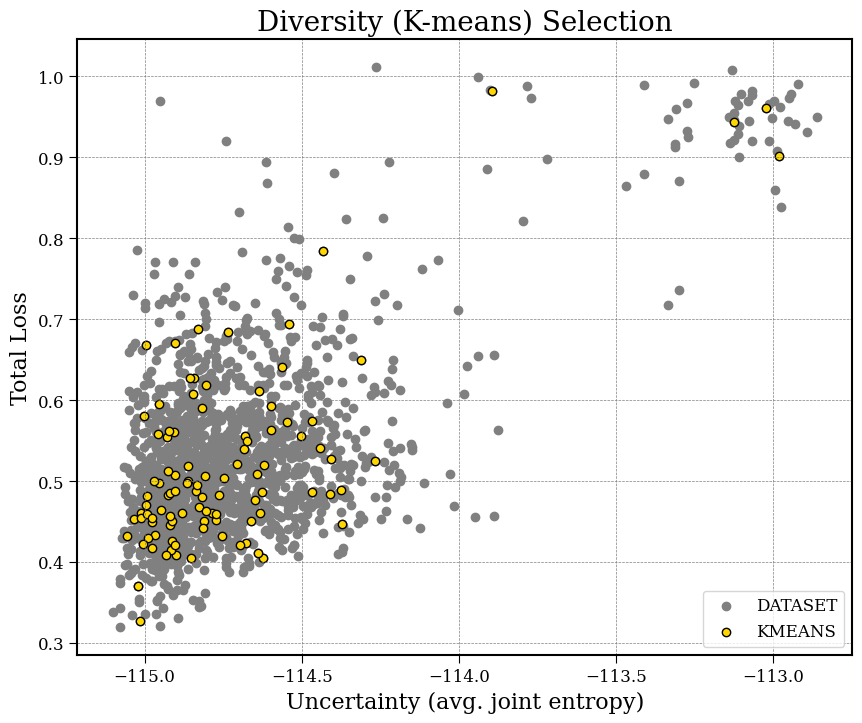

In [6]:
diversity_indices = np.load("ensemble_cache/diversity_selection_indices.npy")

# read diversity selection 
with open("ensemble_cache/diversity_selection.pickle", "rb") as f:
    diversity_selection = pickle.load(f)

# get uncertainty 
# dropout_seeds = np.random.rand(128)

# model_nn_alien = PytorchRegressor(
#     model=model,
#     batch_size=selection_bs,
#     iterate_inputs=False,
#     trainer='lightning',
#     stack_outputs=False, 
#     stack_samples='outer', 
# )


# ensembles = [] # store every ensemble, len(ensembles) == num_batches

# loader = DataLoader(
#     diversity_selection, 
#     batch_size=1, 
#     drop_last=False, 
#     shuffle=False,
#     num_workers=0, 
#     collate_fn=collate_fn, 
#     pin_memory=-True, 
# )

# for x in tqdm(loader, desc="Process over batches..."): 
#     x = x.to(device)
#     ensemble = model_nn_alien.predict_samples(
#         X=x,
#         n=32,
#         seeds=dropout_seeds,
#         use_lightning=False,
#         compute_loss=False, 
#         return_struct=True,
#     )

#     ensemble = [ensemble]
#     masks = [torch.all(torch.where(e == 0, 0, 1), dim=-1, keepdim=True) for e in ensemble]
#     ensemble = [align_ensemble(e) for e in ensemble]
#     ensemble = [e * mask for e, mask in zip(ensemble, masks)]
#     ensemble = [apply_pca(e.view(32, -1), 32, sample_axis=0, top_variance=False) for e in ensemble]
#     ensembles.extend(ensemble) 
# ensembles = torch.stack(ensembles, dim=0)

# # cache the ensemble 
# with open("ensemble_cache/diversity_ensemble_uncertainty.pickle", 'ab') as f: 
#     pickle.dump(ensembles, f)

# load ensemble 
# with open("ensemble_cache/diversity_ensemble_uncertainty.pickle", 'rb') as f: 
#     diversity_ensembles = pickle.load(f)

# jen = joint_entropy_from_ensemble_without_pca(
#     preds=diversity_ensembles,
#     epsilon=1e-3,
#     block_size=50,
#     pbar=True
# )
# # use the sum over all values as the uncertainty measurement 
# uncertainty = jen.mean(axis=-1)


plt.figure(figsize=(10, 8))
plt.title("Diversity (K-means) Selection")
plt.xlabel("Uncertainty (avg. joint entropy)")
plt.ylabel("Total Loss")
plt.scatter((dataset_uncertainty.cpu().detach().numpy()), dataset_losses, color='grey', label='DATASET')
plt.scatter((dataset_uncertainty.cpu().detach().numpy()[diversity_indices]), np.array(dataset_losses)[diversity_indices], label='KMEANS', color='#FFD700',edgecolors='black', linewidths=1)
plt.legend()
plt.savefig("graphs/kmeans_loss_v_uncertainty.png")

## BADGE

In [8]:
# dataloader = DataLoader(
#         dataset, 
#         batch_size=1, 
#         drop_last=False, 
#         shuffle=False,
#         num_workers=0, 
#         collate_fn=collate_fn, 
#         pin_memory=True, 
#     )
# gradient_ensemble = []
# num_blocks = model_grad.num_blocks 
# for data in tqdm(dataloader, desc="Generate gradient ensembles"): 
#     data = data.to(device)
#     model_grad.zero_grad()
#     return_dict = model_grad(data, compute_loss=True, return_struct=False, is_train=False, save_grad=True)
#     gradient_ensemble.append(return_dict['final_block_grad']) 
# gradient_ensemble = torch.stack(gradient_ensemble).cpu().numpy()

In [9]:
# dataset_indices = np.arange(len(dataset))
# badge_indices, _ = kmeans_sample_batch(gradient_ensemble, dataset_indices, selection_bs)

In [10]:
# with open("ensemble_cache/badge_selection.npy", "wb") as handle: 
#     pickle.dump(badge_selection, handle)

In [7]:
# np.save("ensemble_cache/badge_selection_indices.npy", badge_indices)
badge_indices = np.load("ensemble_cache/badge_selection_indices.npy")
# badge_selection = [dataset[ind] for ind in badge_indices]

with open("ensemble_cache/badge_selection.npy", "rb") as handle: 
    badge_selection = pickle.load(handle)

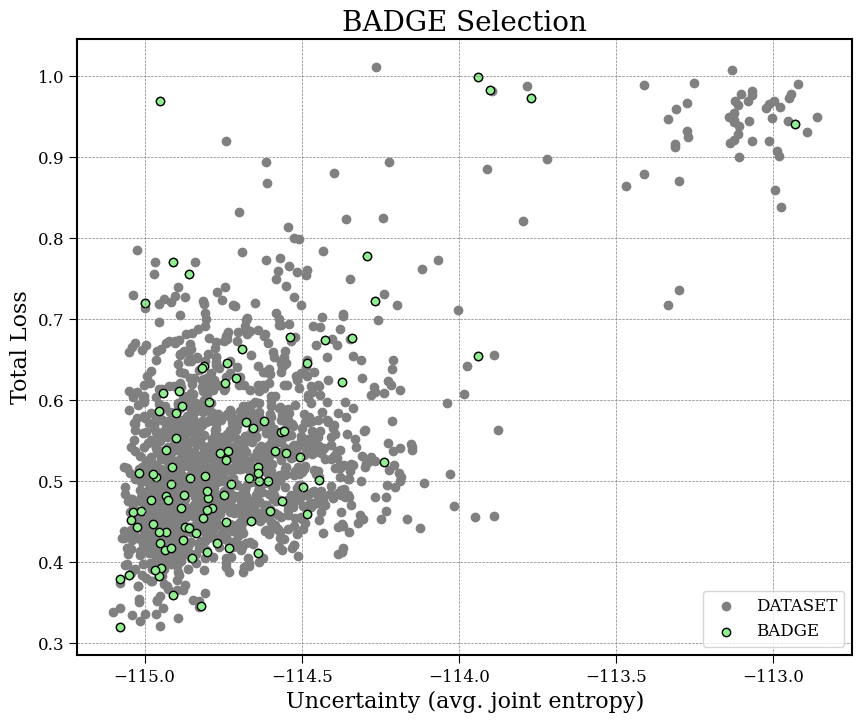

In [8]:
plt.figure(figsize=(10, 8))
plt.title("BADGE Selection")
plt.xlabel("Uncertainty (avg. joint entropy)")
plt.ylabel("Total Loss")
plt.scatter((dataset_uncertainty.cpu().detach().numpy()), dataset_losses, color='grey', label='DATASET')
plt.scatter((dataset_uncertainty.cpu().detach().numpy()[badge_indices]), np.array(dataset_losses)[badge_indices], label="BADGE", color='lightgreen', edgecolors='black', linewidths=1)
plt.legend()
plt.savefig("graphs/badge_loss_v_uncertainty.png")

## DEWDROP

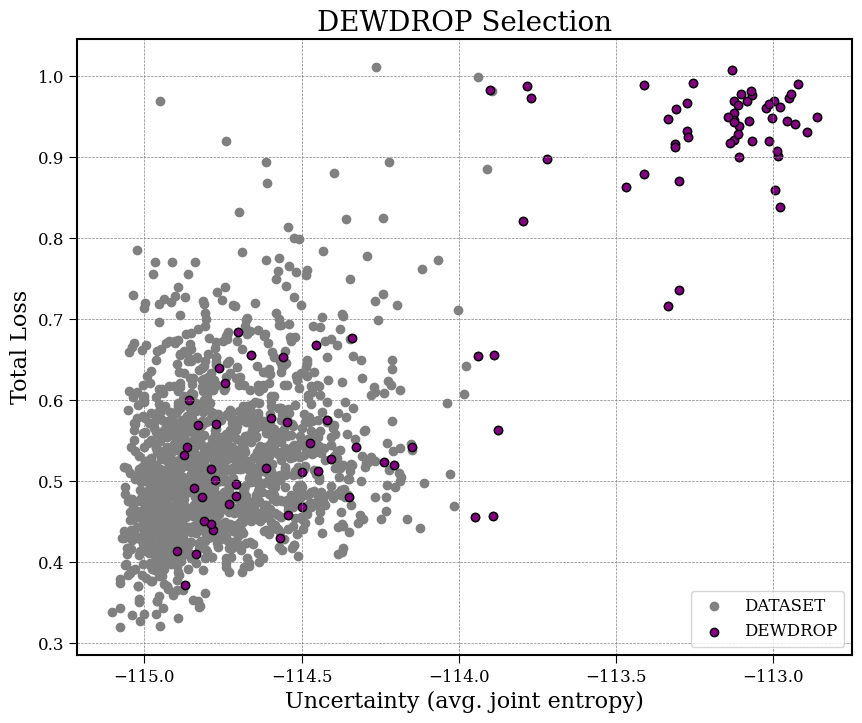

In [13]:
# dewdrop selection 
with open("ensemble_cache/dewdrop_ensemble.pickle", "rb") as f:
    dewdrop_ensemble = pickle.load(f)

# # Calculate Joint Entropy on ensemble 
# jen = joint_entropy_from_ensemble_without_pca(
#     preds=dewdrop_ensemble,
#     epsilon=6e-3,
#     block_size=50,
#     pbar=True
# )

# # Select new batch based on the joint entropy matrix
# dewdrop_selector =  EntropySelector(
#     batch_size=selection_bs,
#     precompute_entropy=True,
#     random_seed=42
# )
# new_batch_indices = dewdrop_selector.select(
#     joint_entropy=jen.to("cpu"),
# ) # need to move to cpu because of calculation with prior

# np.save("ensemble_cache/dewdrop_selection_indices.npy", new_batch_indices)

dewdrop_selection_indices = np.load("ensemble_cache/dewdrop_selection_indices.npy")

dewdrop_selection = [dataset[ind] for ind in dewdrop_selection_indices]

# dewdrop uncertainty
# with open("ensemble_cache/dewdrop_ensemble.pickle", "rb") as f:
#     dewdrop_ensemble = pickle.load(f)
# jen = joint_entropy_from_ensemble_without_pca(
#     preds=dewdrop_ensemble[new_batch_indices],
#     epsilon=6e-3,
#     block_size=50,
#     pbar=True
# )
# dewdrop_uncertainty = jen.mean(axis=-1)

plt.figure(figsize=(10, 8))
plt.title("DEWDROP Selection")
plt.xlabel("Uncertainty (avg. joint entropy)")
plt.ylabel("Total Loss")
plt.scatter((dataset_uncertainty.cpu().detach().numpy()), dataset_losses, color='grey', label='DATASET')
plt.scatter((dataset_uncertainty.cpu().detach().numpy()[dewdrop_selection_indices]), np.array(dataset_losses)[dewdrop_selection_indices], label="DEWDROP", color='purple', edgecolors='black', linewidths=1)
plt.legend()
plt.savefig("graphs/dewdrop_loss_v_uncertainty.png")

## All Together

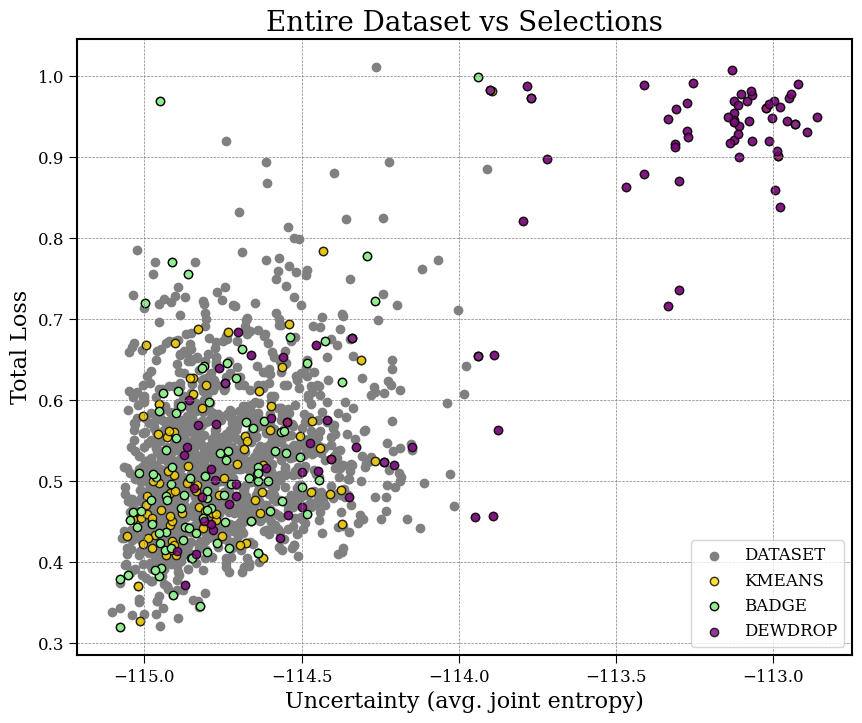

In [14]:
plt.figure(figsize=(10, 8))
plt.title("Entire Dataset vs Selections")
plt.xlabel("Uncertainty (avg. joint entropy)")
plt.ylabel("Total Loss")


plt.scatter((dataset_uncertainty.cpu().detach().numpy()), np.array(dataset_losses), color='grey', label='DATASET')
plt.scatter((dataset_uncertainty.cpu().detach().numpy()[diversity_indices]), np.array(dataset_losses)[diversity_indices], label='KMEANS', c='#FFD700', alpha=0.8, edgecolors='black', linewidths=1)
plt.scatter((dataset_uncertainty.cpu().detach().numpy()[badge_indices]), np.array(dataset_losses)[badge_indices], label='BADGE', color='lightgreen', edgecolors='black', linewidths=1)
# plt.scatter((dataset_uncertainty.cpu().detach().numpy()[coreset_pool]), coreset_losses, label='CORESET', c='lightblue', alpha=0.8, edgecolors='black', linewidths=1)
plt.scatter((dataset_uncertainty.cpu().detach().numpy()[dewdrop_selection_indices]), np.array(dataset_losses)[dewdrop_selection_indices], label='DEWDROP', color='purple', alpha=0.8, edgecolors='black', linewidths=1)
plt.legend()
plt.savefig("graphs/loss_v_uncertainty_nocoreset.png")

## Correlations

In [15]:
# calculate pearson correlation 
np.corrcoef(dataset_uncertainty.cpu().detach().numpy(), dataset_losses)

array([[1.        , 0.64355568],
       [0.64355568, 1.        ]])

In [16]:
np.corrcoef((dataset_uncertainty.cpu().detach().numpy()[diversity_indices]),  np.array(dataset_losses)[diversity_indices])

array([[1.        , 0.71750123],
       [0.71750123, 1.        ]])

In [17]:
np.corrcoef((dataset_uncertainty.cpu().detach().numpy()[coreset_pool]),  np.array(dataset_losses)[coreset_pool])

array([[1.        , 0.57670032],
       [0.57670032, 1.        ]])

In [18]:
np.corrcoef((dataset_uncertainty.cpu().detach().numpy()[badge_indices]),  np.array(dataset_losses)[badge_indices])

array([[1.        , 0.63221801],
       [0.63221801, 1.        ]])

In [19]:
np.corrcoef((dataset_uncertainty.cpu().detach().numpy()[dewdrop_selection_indices]), np.array(dataset_losses)[dewdrop_selection_indices])

array([[1.        , 0.90478107],
       [0.90478107, 1.        ]])

| Overall | K-Means | Coreset | Badge | DEWDROP |
| ------- | ------- | ------- | ------- | ------- | 
|  0.640 | 0.657 | 0.576 | 0.632 | 0.899 | 

## UMAP on Embeddings

In [20]:
# get dataset embeddings
dataset_embedding = []
dataloader = DataLoader(
    dataset, 
    batch_size=1, 
    drop_last=False, 
    shuffle=False,
    num_workers=0, 
    collate_fn=collate_fn, 
    pin_memory=True, 
)
model.eval()
for data in tqdm(dataloader, desc="Generate ensembles"): 
    data = data.to(device)
    model.zero_grad()
    return_dict = model(data)
    s = return_dict['final_block_emb']
    s = s.to('cpu')
    dataset_embedding.append(s.view(-1))
# pad the embeddings to fix length
maxlen = max(len(s) for s in dataset_embedding)
for si in range(len(dataset_embedding)): 
    p1d = (0, maxlen-len(dataset_embedding[si]))
    if p1d[1] != 0: 
        dataset_embedding[si] = torch.nn.functional.pad(dataset_embedding[si], p1d, 'constant', 0.0)
dataset_embedding = torch.stack(dataset_embedding).cpu().detach().numpy()


Generate ensembles: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1708/1708 [10:56<00:00,  2.60it/s]


In [21]:
torch.save(dataset_embedding, "ensemble_cache/dataset_embedding.pickle")

In [22]:
dataset_embedding = torch.load("ensemble_cache/dataset_embedding.pickle")

with open('ensemble_cache/dataset_losses.pickle', 'rb') as handle:
    dataset_losses = pickle.load(handle)

with open("ensemble_cache/dewdrop_ensemble.pickle", "rb") as f:
    dewdrop_ensemble = pickle.load(f)

# Calculate Joint Entropy on ensemble 
jen = joint_entropy_from_ensemble_without_pca(
    preds=dewdrop_ensemble,
    epsilon=6e-3,
    block_size=50,
    pbar=True
)

dataset_uncertainty = jen.mean(axis=-1)

dewdrop_selection_indices = np.load("ensemble_cache/dewdrop_selection_indices.npy")
badge_indices = np.load("ensemble_cache/badge_selection_indices.npy")
diversity_indices = np.load("ensemble_cache/diversity_selection_indices.npy")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 630/630 [00:01<00:00, 320.11it/s]


In [23]:
# get the uncertainty from different selection strategy
dewdrop_uncertainty = dataset_uncertainty[dewdrop_selection_indices]
badge_uncertainty = dataset_uncertainty[badge_indices]
kmeans_uncertainty = dataset_uncertainty[diversity_indices]

In [24]:
# construct strategy label for all data samples 
dataset_df = pd.DataFrame(dataset_embedding)
strategy = np.repeat('dataset', len(dataset_df))
strategy[dewdrop_selection_indices] = 'dewdrop'
strategy[badge_indices] = 'badge'
strategy[diversity_indices] = 'kmeans'
dataset_df['strategy'] = strategy

In [25]:
# get embeddings based on different selection strategy 
dewdrop_embedding = dataset_embedding[dewdrop_selection_indices]
badge_embedding = dataset_embedding[badge_indices]
kmeans_embedding = dataset_embedding[diversity_indices]

In [26]:
# get the correlation between each selection with a correlation plot 
dewdrop_df = pd.DataFrame(dewdrop_embedding)
dewdrop_df['strategy'] = np.repeat('dewdrop', len(dewdrop_df))
badge_df = pd.DataFrame(badge_embedding)
badge_df['strategy'] = np.repeat('badge', len(badge_df))
kmeans_df = pd.DataFrame(kmeans_embedding)
kmeans_df['strategy'] = np.repeat('kmeans', len(kmeans_df))
dewdrop_df.shape, badge_df.shape, kmeans_df.shape
embedding_df = pd.concat([dewdrop_df, badge_df, kmeans_df], axis=0)


In [27]:
# embedding_df = pd.DataFrame({
#     'dewdrop': dewdrop_embedding.flatten(), 
#     'badge': badge_embedding.flatten(), 
#     'kmeans': kmeans_embedding.flatten(),
# })
# import seaborn as sns
# sns.pairplot(embedding_df, hue='strategy')

In [28]:
# do umap projection 
import umap 
reducer = umap.UMAP(n_neighbors=5, min_dist=0.1)
embedding_data = dataset_df.drop(columns=['strategy']).values
umap_embedding = reducer.fit_transform(embedding_data)

In [29]:
umap_dewdrop = umap_embedding[dewdrop_selection_indices]
umap_badge = umap_embedding[badge_indices]
umap_kmeans = umap_embedding[diversity_indices]

/tmp/ipykernel_1160538/2248011432.py:3: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], label="Dataset", alpha=0.5, c=sns.color_palette()[7])
/tmp/ipykernel_1160538/2248011432.py:4: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(umap_kmeans[:, 0], umap_kmeans[:, 1], label="KMEANS", c=sns.color_palette()[2])
/tmp/ipykernel_1160538/2248011432.py:5: UserWarning: *

Text(0.5, 1.0, 'UMAP projection of the Different Strategy')

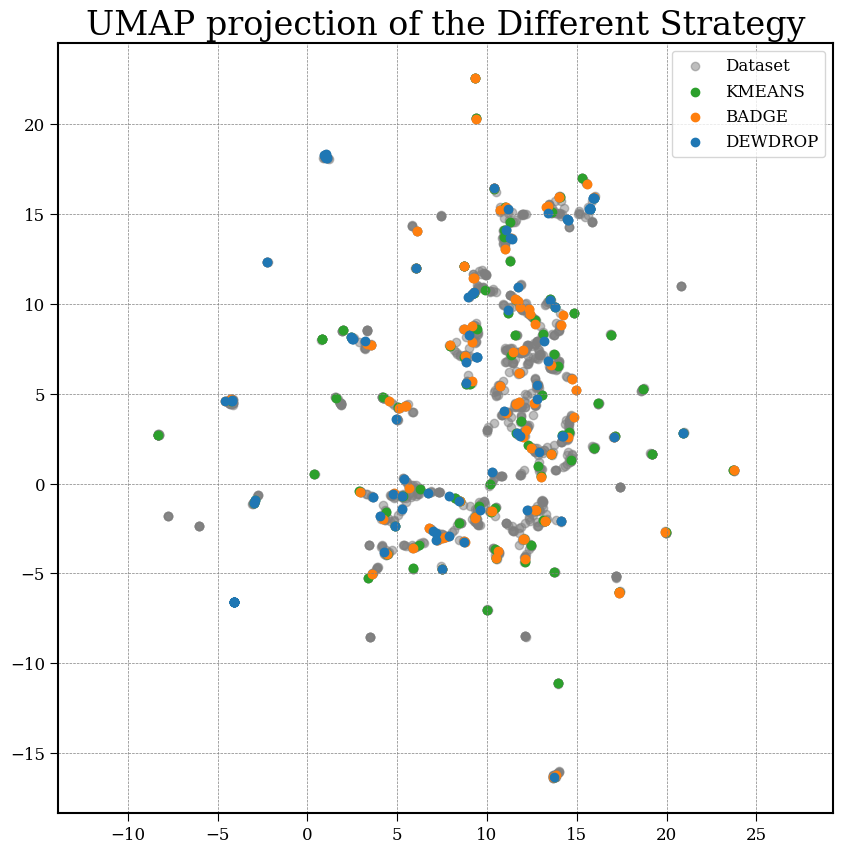

In [30]:
import seaborn as sns
plt.figure(figsize=(10,10))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], label="Dataset", alpha=0.5, c=sns.color_palette()[7])
plt.scatter(umap_kmeans[:, 0], umap_kmeans[:, 1], label="KMEANS", c=sns.color_palette()[2])
plt.scatter(umap_badge[:, 0], umap_badge[:, 1], label="BADGE", c=sns.color_palette()[1])
plt.scatter(umap_dewdrop[:, 0], umap_dewdrop[:, 1], label="DEWDROP", c=sns.color_palette()[0])
plt.gca().set_aspect('equal', 'datalim')
plt.legend()
plt.title('UMAP projection of the Different Strategy', fontsize=24)

In [31]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [32]:
# load partially train model
# CONFIG = configparser.ConfigParser(interpolation=configparser.ExtendedInterpolation())
# CONFIG.read("config_recycle.ini")

# model_path = CONFIG["inference"]["model_ckpt"]
# config_path = CONFIG["inference"]["config_path"]
# with open(config_path, "r") as f:
#     config = json.load(f)

# model = NN(**config)
# model_grad = NN_grad(**config)

# checkpoint = torch.load(model_path, map_location="cpu")
# try:
#     model.load_state_dict(checkpoint["state_dict"])
#     model_grad.load_state_dict(checkpoint["state_dict"])
# except:
#     model.load_state_dict(checkpoint)
#     model_grad.load_state_dict(checkpoint["state_dict"])
# model = model.to(device)
# model_grad = model_grad.to(device)
# model.eval()
# model_grad.eval()

## Show data drift

In [33]:
# kmeans model 
CONFIG = configparser.ConfigParser(interpolation=configparser.ExtendedInterpolation())
CONFIG.read("config_kmeans_oneround.ini")
initial_weights = "model_logs/kmeans_oneround/kmeans_oneround/v1/weights_v1.pt"
model_kmeans = NN(**config).to(device)
model_kmeans.load_state_dict(torch.load(initial_weights))

# badge model 
CONFIG = configparser.ConfigParser(interpolation=configparser.ExtendedInterpolation())
CONFIG.read("config_badge_oneround.ini")
initial_weights = "model_logs/badge_oneround/badge_oneround/v1/weights_v1.pt"
model_badge = NN(**config).to(device)
model_badge.load_state_dict(torch.load(initial_weights))

# dewdrop model 
CONFIG = configparser.ConfigParser(interpolation=configparser.ExtendedInterpolation())
CONFIG.read("config_dewdrop_oneround.ini")
initial_weights = "model_logs/dewdrop_oneround/dewdrop_oneround/v1/weights_v1.pt"
model_dewdrop = NN(**config).to(device)
model_dewdrop.load_state_dict(torch.load(initial_weights))

<All keys matched successfully>

In [34]:
# # kmeans
# # torch.cuda.empty_cache()
# dataset_loss_kmeansmodel, dataset_uncertainty_kmeansmodel = [], []
# dataset_loader = DataLoader(
#     dataset, 
#     batch_size=1, 
#     drop_last=False, 
#     shuffle=False,
#     num_workers=0, 
#     collate_fn=collate_fn, 
#     pin_memory=True, 
# )
# model_kmeans.eval() 
# for data in tqdm(dataset_loader, desc="Calculating loss"): 
#     data = data.to(device)
#     model_kmeans.zero_grad()
#     return_dict = model_kmeans(data, compute_loss=True, return_struct=True)
#     loss = return_dict['loss_total'].cpu().detach().item()
#     dataset_loss_kmeansmodel.append(loss)
    
# # get uncertainty 
# dropout_seeds = np.random.rand(32)
# model_nn_alien = PytorchRegressor(
#     model=model_kmeans,
#     batch_size=selection_bs,
#     iterate_inputs=False,
#     trainer='lightning',
#     stack_outputs=False, 
#     stack_samples='outer', 
# )
# ensembles = [] # store every ensemble, len(ensembles) == num_batches
# loader = DataLoader(
#     dataset, 
#     batch_size=1, 
#     drop_last=False, 
#     shuffle=False,
#     num_workers=0, 
#     collate_fn=collate_fn, 
#     pin_memory=-True, 
# )

# for x in tqdm(loader, desc="Process over batches..."): 
#     x = x.to(device)
#     dataset_ensembles = model_nn_alien.predict_samples(
#         X=x,
#         n=32,
#         seeds=dropout_seeds,
#         use_lightning=False,
#         compute_loss=False, 
#         return_struct=True,
#     )

#     dataset_ensembles = [dataset_ensembles]
#     masks = [torch.all(torch.where(e == 0, 0, 1), dim=-1, keepdim=True) for e in dataset_ensembles]
#     dataset_ensembles = [align_ensemble(e) for e in dataset_ensembles]
#     dataset_ensembles = [e * mask for e, mask in zip(dataset_ensembles, masks)]
#     dataset_ensembles = [apply_pca(e.view(32, -1), 32, sample_axis=0, top_variance=False) for e in dataset_ensembles]
#     dataset_ensembles.extend(dataset_ensembles) 
# dataset_ensembles = torch.stack(dataset_ensembles, dim=0)

# dataset_jen = joint_entropy_from_ensemble_without_pca(
#     preds=dataset_ensembles,
#     epsilon=1e-1,
#     block_size=50,
#     pbar=True
# )
# dataset_uncertainty_kmeansmodel = dataset_jen.mean(axis=-1)

# # # extract the sequences' embeddings 
# # sequences_embedding = extract_embedding(dataset, dataset_index, model_kmeans)

# # # pad the embeddings to fix length
# # maxlen = max(len(s) for s in sequences_embedding)
# # for si in range(len(sequences_embedding)): 
# #     p1d = (0, maxlen-len(sequences_embedding[si]))
# #     if p1d[1] != 0: 
# #         sequences_embedding[si] = torch.nn.functional.pad(sequences_embedding[si], p1d, 'constant', 0.0)
# # sequences_embedding = torch.stack(sequences_embedding).cpu().detach().numpy()

# # from sklearn.cluster import KMeans
# # from sklearn.metrics import pairwise_distances_argmin_min
# # kmeans = KMeans(n_clusters=selection_bs, random_state=42)
# # kmeans.fit(sequences_embedding)
# # centroids = kmeans.cluster_centers_
# # kmeans_oneround_indices = pairwise_distances_argmin_min(centroids, sequences_embedding)[0]

# # kmeans_losses, kmeans_oneround_losses = np.array(dataset_losses)[diversity_indices], []
# # dataset_loader = DataLoader(
# #     [dataset[i] for i in kmeans_oneround_indices], 
# #     batch_size=1, 
# #     drop_last=False, 
# #     shuffle=False,
# #     num_workers=0, 
# #     collate_fn=collate_fn, 
# #     pin_memory=True, 
# # )
# # model_kmeans.eval() 
# # for data in tqdm(dataset_loader, desc="Calculating loss"): 
# #     data = data.to(device)
# #     model_kmeans.zero_grad()
# #     return_dict = model_kmeans(data, compute_loss=True)
# #     loss = return_dict['loss_total'].cpu().detach().item()
# #     kmeans_oneround_losses.append(loss)


# # # get uncertainty 
# # dropout_seeds = np.random.rand(32)
# # model_nn_alien = PytorchRegressor(
# #     model=model_kmeans,
# #     batch_size=selection_bs,
# #     iterate_inputs=False,
# #     trainer='lightning',
# #     stack_outputs=False, 
# #     stack_samples='outer', 
# # )
# # ensembles = [] # store every ensemble, len(ensembles) == num_batches
# # loader = DataLoader(
# #     [dataset[i] for i in kmeans_oneround_indices], 
# #     batch_size=1, 
# #     drop_last=False, 
# #     shuffle=False,
# #     num_workers=0, 
# #     collate_fn=collate_fn, 
# #     pin_memory=-True, 
# # )

# # for x in tqdm(loader, desc="Process over batches..."): 
# #     x = x.to(device)
# #     ensemble = model_nn_alien.predict_samples(
# #         X=x,
# #         n=32,
# #         seeds=dropout_seeds,
# #         use_lightning=False,
# #         compute_loss=False, 
# #         return_struct=True,
# #     )

# #     ensemble = [ensemble]
# #     masks = [torch.all(torch.where(e == 0, 0, 1), dim=-1, keepdim=True) for e in ensemble]
# #     ensemble = [align_ensemble(e) for e in ensemble]
# #     ensemble = [e * mask for e, mask in zip(ensemble, masks)]
# #     ensemble = [apply_pca(e.view(32, -1), 32, sample_axis=0, top_variance=False) for e in ensemble]
# #     ensembles.extend(ensemble) 
# # ensembles = torch.stack(ensembles, dim=0)

# jen = joint_entropy_from_ensemble_without_pca(
#     preds=ensembles,
#     epsilon=1e-1,
#     block_size=50,
#     pbar=True
# )
# kmeans_oneround_uncertainty = jen.mean(axis=-1)
# kmeans_uncertainty = dataset_uncertainty.cpu().detach().numpy()[diversity_indices] 

# plt.figure(figsize=(10, 8))
# plt.title("Diversity (K-means) Selection")
# plt.xlabel("Uncertainty (avg. joint entropy)")
# plt.ylabel("Total Loss")
# plt.scatter((dataset_uncertainty.cpu().detach().numpy()), np.abs(np.array(dataset_losses)), color='grey', label='DATASET')
# plt.scatter(kmeans_uncertainty, np.abs(kmeans_losses), color='#FFEA70', label='Pre-trained')
# plt.scatter(kmeans_oneround_uncertainty, np.abs(kmeans_oneround_losses), label='One Round of Selection', color='#FFD700', edgecolors='black', linewidths=1)
# plt.legend()
# plt.savefig("graphs/kmeans_loss_v_uncertainty_oneround.png")

In [35]:
# # badge
# torch.cuda.empty_cache()
# # extract the sequences' gradient embeddings 
# dataloader = DataLoader(
#         dataset, 
#         batch_size=1, 
#         drop_last=False, 
#         shuffle=False,
#         num_workers=0, 
#         collate_fn=collate_fn, 
#         pin_memory=True, 
#     )
# gradient_ensemble = []
# model_badge.eval()
# num_blocks = model_badge.num_blocks 
# for data in tqdm(dataloader, desc="Generate gradient ensembles"): 
#     data = data.to(device)
#     model_badge.zero_grad()
#     return_dict = model_badge(data, compute_loss=True, return_struct=False, is_train=False, save_grad=True)
#     gradient_ensemble.append(return_dict['final_block_grad']) 
# gradient_ensemble = torch.stack(gradient_ensemble).cpu().numpy()
# badge_oneround_indices, _ = kmeans_sample_batch(gradient_ensemble, dataset_indices, selection_bs)

# badge_losses, badge_oneround_losses = np.array(dataset_losses)[badge_indices], []
# dataset_loader = DataLoader(
#     [dataset[i] for i in badge_oneround_indices], 
#     batch_size=1, 
#     drop_last=False, 
#     shuffle=False,
#     num_workers=0, 
#     collate_fn=collate_fn, 
#     pin_memory=True, 
# )
# model_badge.eval()
# for data in tqdm(dataset_loader, desc="Calculating loss"): 
#     data = data.to(device)
#     model_badge.zero_grad()
#     return_dict = model_badge(data, compute_loss=True)
#     loss = return_dict['loss_total'].cpu().detach().item()
#     badge_oneround_losses.append(loss)


# # get uncertainty 
# dropout_seeds = np.random.rand(32)
# model_nn_alien = PytorchRegressor(
#     model=model_badge,
#     batch_size=selection_bs,
#     iterate_inputs=False,
#     trainer='lightning',
#     stack_outputs=False, 
#     stack_samples='outer', 
# )
# ensembles = [] # store every ensemble, len(ensembles) == num_batches
# loader = DataLoader(
#     [dataset[i] for i in badge_oneround_indices], 
#     batch_size=1, 
#     drop_last=False, 
#     shuffle=False,
#     num_workers=0, 
#     collate_fn=collate_fn, 
#     pin_memory=-True, 
# )

# for x in tqdm(loader, desc="Process over batches..."): 
#     x = x.to(device)
#     ensemble = model_nn_alien.predict_samples(
#         X=x,
#         n=32,
#         seeds=dropout_seeds,
#         use_lightning=False,
#         compute_loss=False, 
#         return_struct=True,
#     )

#     ensemble = [ensemble]
#     masks = [torch.all(torch.where(e == 0, 0, 1), dim=-1, keepdim=True) for e in ensemble]
#     ensemble = [align_ensemble(e) for e in ensemble]
#     ensemble = [e * mask for e, mask in zip(ensemble, masks)]
#     ensemble = [apply_pca(e.view(32, -1), 32, sample_axis=0, top_variance=False) for e in ensemble]
#     ensembles.extend(ensemble) 
# ensembles = torch.stack(ensembles, dim=0)

# jen = joint_entropy_from_ensemble_without_pca(
#     preds=ensembles,
#     epsilon=1e-3,
#     block_size=50,
#     pbar=True
# )
# badge_oneround_uncertainty = jen.mean(axis=-1)
# badge_uncertainty = dataset_uncertainty.cpu().detach().numpy()[badge_indices] 

# plt.figure(figsize=(10, 8))
# plt.title("BADGE Selection")
# plt.xlabel("Uncertainty (avg. joint entropy)")
# plt.ylabel("Total Loss")
# plt.scatter(badge_uncertainty, badge_losses, color='lightgreen', label='Pre-trained')
# plt.scatter(badge_oneround_uncertainty, badge_oneround_losses, label='One Round of Selection', color='green', edgecolors='black', linewidths=1)
# plt.legend()
# plt.savefig("graphs/badge_loss_v_uncertainty_oneround.png")

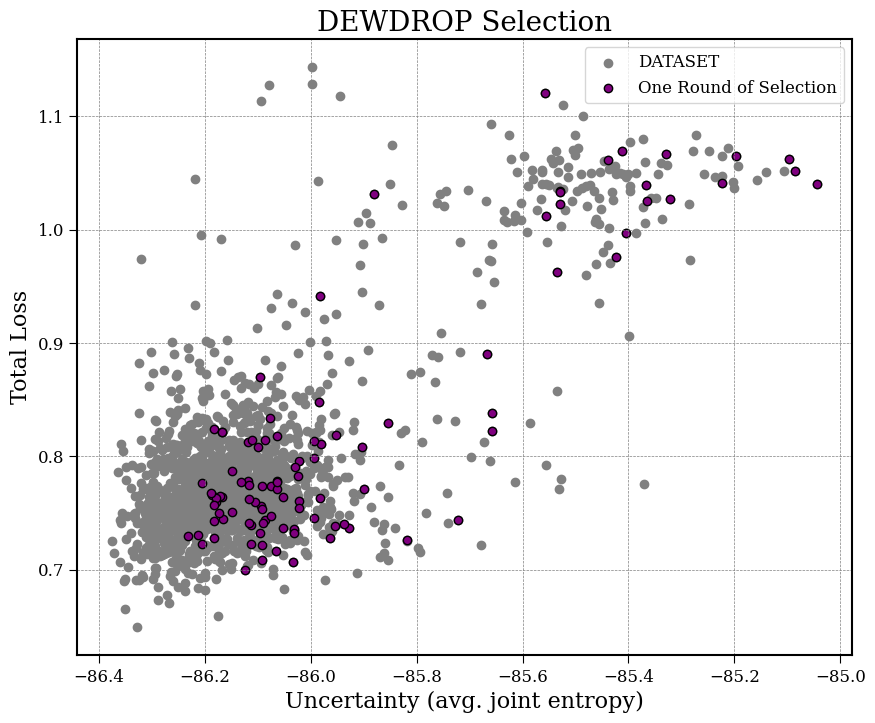

In [49]:
# dewdrop
torch.cuda.empty_cache()
# get uncertainty 
# dropout_seeds = np.random.rand(32)
# model_nn_alien = PytorchRegressor(
#     model=model_dewdrop,
#     batch_size=selection_bs,
#     iterate_inputs=False,
#     trainer='lightning',
#     stack_outputs=False, 
#     stack_samples='outer', 
# )
# ensembles = [] # store every ensemble, len(ensembles) == num_batches
# loader = DataLoader(
#     dataset, 
#     batch_size=1, 
#     drop_last=False, 
#     shuffle=False,
#     num_workers=0, 
#     collate_fn=collate_fn, 
#     pin_memory=-True, 
# )
# for x in tqdm(loader, desc="Process over batches..."): 
#     x = x.to(device)
#     ensemble = model_nn_alien.predict_samples(
#         X=x,
#         n=32,
#         seeds=dropout_seeds,
#         use_lightning=False,
#         compute_loss=False, 
#         return_struct=True,
#     )
#     ensemble = [ensemble]
#     masks = [torch.all(torch.where(e == 0, 0, 1), dim=-1, keepdim=True) for e in ensemble]
#     ensemble = [align_ensemble(e) for e in ensemble]
#     ensemble = [e * mask for e, mask in zip(ensemble, masks)]
#     ensemble = [apply_pca(e.view(32, -1), 32, sample_axis=0, top_variance=False) for e in ensemble]
#     ensembles.extend(ensemble) 
# ensembles = torch.stack(ensembles, dim=0)

# torch.save(ensemble, "ensemble_cache/dataset_ensemble_dewdropmodel.pt")
# ensemble = torch.load("ensemble_cache/dataset_ensemble_dewdropmodel.pt")

# jen = joint_entropy_from_ensemble_without_pca(
#     preds=ensembles,
#     epsilon=2e-2,
#     block_size=50,
#     pbar=True
# )
# # Select new batch based on the joint entropy matrix
# dewdrop_selector = EntropySelector(
#     batch_size=selection_bs,
#     precompute_entropy=True,
#     random_seed=42
# )
# dewdrop_oneround_indicies = dewdrop_selector.select(
#     joint_entropy=jen.to("cpu"),
# ) # need to move to cpu because of calculation with prior

# dewdrop_oneround_uncertainty = jen.mean(axis=-1)[dewdrop_oneround_indicies]
# dewdrop_uncertainty = dataset_uncertainty.cpu().detach().numpy()[dewdrop_selection_indices] 

# dewdrop_losses, dewdrop_oneround_losses = np.array(dataset_losses)[dewdrop_selection_indices], []
# dataset_uncertainty = jen.mean(axis=-1)
# dataset_losses = []
# dataset_loader = DataLoader(
#     dataset, 
#     batch_size=1, 
#     drop_last=False, 
#     shuffle=False,
#     num_workers=0, 
#     collate_fn=collate_fn, 
#     pin_memory=True, 
# )
# model_dewdrop.eval()
# for data in tqdm(dataset_loader, desc="Calculating loss"): 
#     data = data.to(device)
#     model_dewdrop.zero_grad()
#     return_dict = model_dewdrop(data, compute_loss=True)
#     loss = return_dict['loss_total'].cpu().detach().item()
#     dataset_losses.append(loss)

dewdrop_oneround_losses = [dataset_losses[i] for i in dewdrop_oneround_indicies]

plt.figure(figsize=(10, 8))
plt.title("DEWDROP Selection")
plt.xlabel("Uncertainty (avg. joint entropy)")
plt.ylabel("Total Loss")
# plt.scatter(dewdrop_uncertainty, dewdrop_losses, color='pink', label='Pre-trained')
plt.scatter(dataset_uncertainty, dataset_losses, label='DATASET', color='grey')
plt.scatter(dewdrop_oneround_uncertainty, dewdrop_oneround_losses, label='One Round of Selection', color='purple', edgecolors='black', linewidths=1)
plt.legend()
plt.savefig("graphs/badge_loss_v_uncertainty_oneround.png")

  0%|                                                                                                                                                                                                              | 0/630 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 630/630 [00:01<00:00, 323.80it/s]


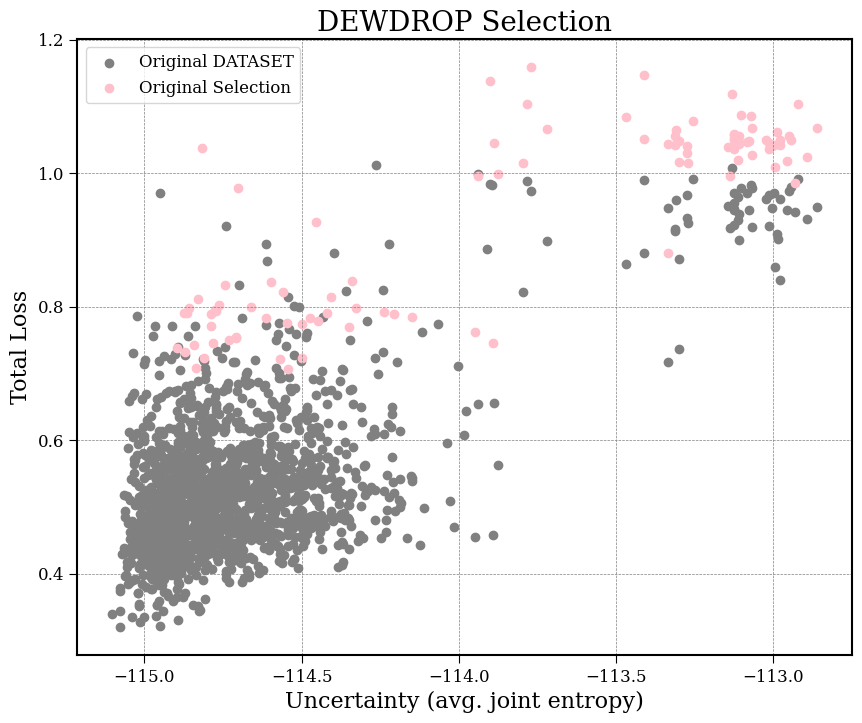

In [50]:
# dewdrop
torch.cuda.empty_cache()
# get uncertainty 
# dropout_seeds = np.random.rand(32)
# model_nn_alien = PytorchRegressor(
#     model=model_dewdrop,
#     batch_size=selection_bs,
#     iterate_inputs=False,
#     trainer='lightning',
#     stack_outputs=False, 
#     stack_samples='outer', 
# )
# ensembles = [] # store every ensemble, len(ensembles) == num_batches
# loader = DataLoader(
#     dataset, 
#     batch_size=1, 
#     drop_last=False, 
#     shuffle=False,
#     num_workers=0, 
#     collate_fn=collate_fn, 
#     pin_memory=-True, 
# )
# for x in tqdm(loader, desc="Process over batches..."): 
#     x = x.to(device)
#     ensemble = model_nn_alien.predict_samples(
#         X=x,
#         n=32,
#         seeds=dropout_seeds,
#         use_lightning=False,
#         compute_loss=False, 
#         return_struct=True,
#     )
#     ensemble = [ensemble]
#     masks = [torch.all(torch.where(e == 0, 0, 1), dim=-1, keepdim=True) for e in ensemble]
#     ensemble = [align_ensemble(e) for e in ensemble]
#     ensemble = [e * mask for e, mask in zip(ensemble, masks)]
#     ensemble = [apply_pca(e.view(32, -1), 32, sample_axis=0, top_variance=False) for e in ensemble]
#     ensembles.extend(ensemble) 
# ensembles = torch.stack(ensembles, dim=0)

# torch.save(ensemble, "ensemble_cache/dataset_ensemble_dewdropmodel.pt")
# ensemble = torch.load("ensemble_cache/dataset_ensemble_dewdropmodel.pt")

# jen = joint_entropy_from_ensemble_without_pca(
#     preds=ensembles,
#     epsilon=2e-2,
#     block_size=50,
#     pbar=True
# )
# # Select new batch based on the joint entropy matrix
# dewdrop_selector = EntropySelector(
#     batch_size=selection_bs,
#     precompute_entropy=True,
#     random_seed=42
# )
# dewdrop_oneround_indicies = dewdrop_selector.select(
#     joint_entropy=jen.to("cpu"),
# ) # need to move to cpu because of calculation with prior

# dewdrop_oneround_uncertainty = jen.mean(axis=-1)[dewdrop_oneround_indicies]
# dewdrop_uncertainty = dataset_uncertainty.cpu().detach().numpy()[dewdrop_selection_indices] 

# dewdrop_losses, dewdrop_oneround_losses = np.array(dataset_losses)[dewdrop_selection_indices], []
# dataset_uncertainty = jen.mean(axis=-1)
# dataset_losses = []
# dataset_loader = DataLoader(
#     dataset, 
#     batch_size=1, 
#     drop_last=False, 
#     shuffle=False,
#     num_workers=0, 
#     collate_fn=collate_fn, 
#     pin_memory=True, 
# )
# model_dewdrop.eval()
# for data in tqdm(dataset_loader, desc="Calculating loss"): 
#     data = data.to(device)
#     model_dewdrop.zero_grad()
#     return_dict = model_dewdrop(data, compute_loss=True)
#     loss = return_dict['loss_total'].cpu().detach().item()
#     dataset_losses.append(loss)

# dewdrop_oneround_losses = [dataset_losses[i] for i in dewdrop_selection_indices]

with open('ensemble_cache/dataset_losses.pickle', 'rb') as handle:
    original_dataset_losses = pickle.load(handle)

with open("ensemble_cache/dewdrop_ensemble.pickle", "rb") as f:
    original_dataset_ensemble = pickle.load(f)

# Calculate Joint Entropy on ensemble 
original_jen = joint_entropy_from_ensemble_without_pca(
    preds=original_dataset_ensemble,
    epsilon=6e-3,
    block_size=50,
    pbar=True
)

original_dataset_uncertainty = original_jen.mean(axis=-1)

plt.figure(figsize=(10, 8))
plt.title("DEWDROP Selection")
plt.xlabel("Uncertainty (avg. joint entropy)")
plt.ylabel("Total Loss")
plt.scatter(original_dataset_uncertainty, original_dataset_losses, label='Original DATASET', color='grey')
plt.scatter(dewdrop_uncertainty, dewdrop_losses, label="Original Selection", color='pink')
# plt.scatter(dewdrop_oneround_uncertainty, dewdrop_oneround_losses, label='One Round of Selection', color='purple', edgecolors='black', linewidths=1)
plt.legend()
plt.savefig("graphs/badge_loss_v_uncertainty_oneround.png")